# Pan01 surface fluxes

Variables:
- `wfo` = Water Flux Into Sea Water
   - Net surface water flux into the ocean, including precipitation, evaporation, river runoff, and sea ice melt/freeze. Positive into the ocean.
- `fsitherm` = water flux to ocean from sea ice melt(> 0) or form(< 0)
- `salt_flux` = Net salt flux into ocean at surface (restoring + sea-ice)
- `salt_flux_added` = Salt flux into ocean at surface due to restoring or flux adjustment

In [1]:
import intake
import glob
import dask.distributed as dsk
import matplotlib.pyplot as plt
import xarray as xr
import cf_xarray as cfxr
import numpy as np
import xesmf as xe

import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
from os import environ
environ["PYTHONWARNINGS"] = "ignore"

from dask.distributed import Client
client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45901,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:41569,Total threads: 1
Dashboard: /proxy/38427/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:44147,


In [3]:
# Importing data
pathsC = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/*/*.ocean_month.nc'))
pathsM = np.sort(glob.glob('/scratch/x77/jn8053/mom6/archive/panant-01-zstar-ssp126-prsc-rest/*/*.ocean_month.nc'))

In [4]:
lat_slice = slice(None,-59)
time_slice = slice('2001-01-01','2010-12-31')

In [5]:
# Time variant variables
def preprocess_1(ds):
    ds = ds[['salt_flux_added','salt_flux','fsitherm','wfo']].sel(yh=lat_slice) 
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess_1, chunks = 'auto')
melt = xr.open_mfdataset(pathsM, preprocess = preprocess_1, chunks = 'auto')

In [6]:
cont = cont.sel(time= time_slice)
melt = melt.sel(time = time_slice)

In [7]:
# Area
area = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['areacello']
var = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_month_z.nc')['so'].isel(z_l=0,time=0)

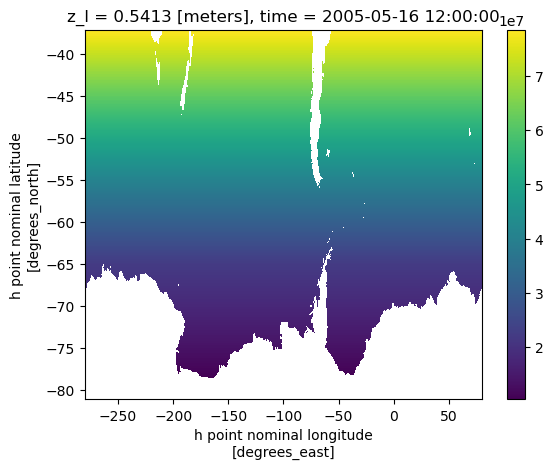

In [8]:
area_corr = area*(var*0 +1)
area_corr.plot()

In [9]:
# Shelf mask

def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [10]:
depth = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['deptho']
land_mask = (0 * depth).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom6_01')

# Water mass flux

 Let's look at water mass flux first.

In [11]:
water_C = cont['wfo']
water_M = melt['wfo']

Time series over shelf

In [12]:
water_shelf_C = water_C.where(shelf_mask ==1)
water_shelf_M = water_M.where(shelf_mask ==1)

In [13]:
# Spatial average
water_time_C = (area_corr * water_shelf_C).sum(['xh', 'yh']) / area_corr.where(shelf_mask == 1).sum(['xh', 'yh'])
water_time_M = (area_corr * water_shelf_M).sum(['xh', 'yh']) / area_corr.where(shelf_mask == 1).sum(['xh', 'yh'])

In [15]:
water_time_C = water_time_C.load()
water_time_M = water_time_M.load()

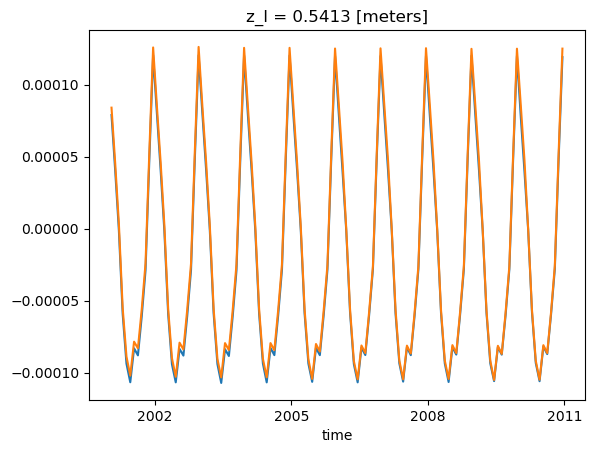

In [16]:
water_time_C.plot()
water_time_M.plot()

In [17]:
water_shelf_anom = water_time_M - water_time_C
water_shelf_anom = water_shelf_anom.load()

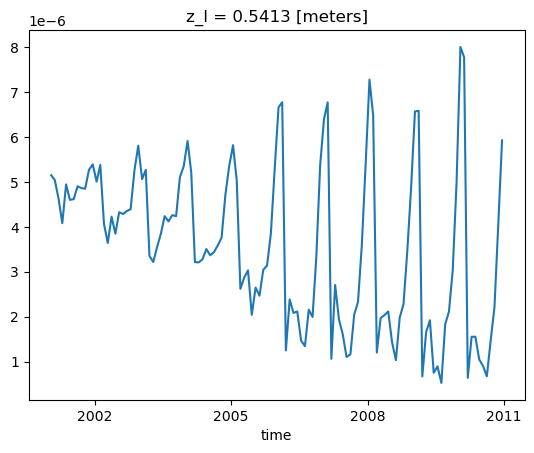

In [19]:
water_shelf_anom.plot()

In [20]:
water_shelf_anom.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/wfo_shelf_time_prescribed_Pan01.nc')

Oscillating around 5e-6, is this because of how the model drifts fresher?

### Quick comparison to ACCESS

In [26]:
wfo_shelf_pan = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/wfo_shelf_time_prescribed_Pan01.nc')
wfo_shelf_acc = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/wfo_shelf_time_prescribed_ACCESS.nc')

In [29]:
wfo_shelf_pan_new = wfo_shelf_pan.to_series()
wfo_shelf_acc_new = wfo_shelf_acc.to_series()

In [30]:
wfo_shelf_pan_new = wfo_shelf_pan_new['2001-01-01':'2010-12-16']
wfo_shelf_acc_new = wfo_shelf_acc_new['1910-01-01':'1919-12-16']

# Reset index to normalized months
wfo_shelf_pan_new.index = range(1, len(wfo_shelf_pan_new)+1)
wfo_shelf_acc_new.index = range(1, len(wfo_shelf_acc_new)+1)

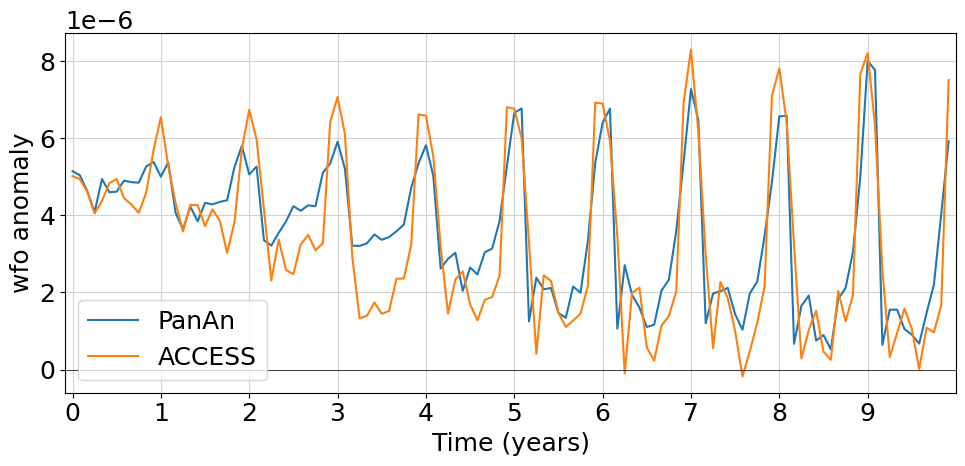

In [33]:
plt.rcParams['font.size'] = 18

plt.figure(figsize=(10, 5))
plt.plot(wfo_shelf_pan_new.index, wfo_shelf_pan_new.values, label='PanAn')
plt.plot(wfo_shelf_acc_new.index, wfo_shelf_acc_new.values, label='ACCESS')

# Set x-axis ticks to represent years 1 through 10
plt.xticks(ticks=range(1, 121, 12), labels=[str(i) for i in range(0, 10)])

# Labeling and formatting
plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel('Time (years)')
plt.ylabel("wfo anomaly")
plt.title('')
plt.legend()
plt.xlim(0,121)
plt.grid(True, color='lightgrey')
plt.tight_layout()
plt.show()

Hm, the last 5 years is pretty similar for water mass flux.  
Now let's check salinity surface fluxes.

# Salinity surface flux

In [34]:
salt_C = cont['salt_flux']
salt_M = melt['salt_flux']

In [35]:
salt_shelf_C = salt_C.where(shelf_mask ==1)
salt_shelf_M = salt_M.where(shelf_mask ==1)

In [36]:
# Spatial average
salt_time_C = (area_corr * salt_shelf_C).sum(['xh', 'yh']) / area_corr.where(shelf_mask == 1).sum(['xh', 'yh'])
salt_time_M = (area_corr * salt_shelf_M).sum(['xh', 'yh']) / area_corr.where(shelf_mask == 1).sum(['xh', 'yh'])

In [38]:
salt_time_C = salt_time_C.load()
salt_time_M = salt_time_M.load()

In [39]:
salt_shelf_anom = salt_time_M - salt_time_C
salt_shelf_anom = salt_shelf_anom.load()

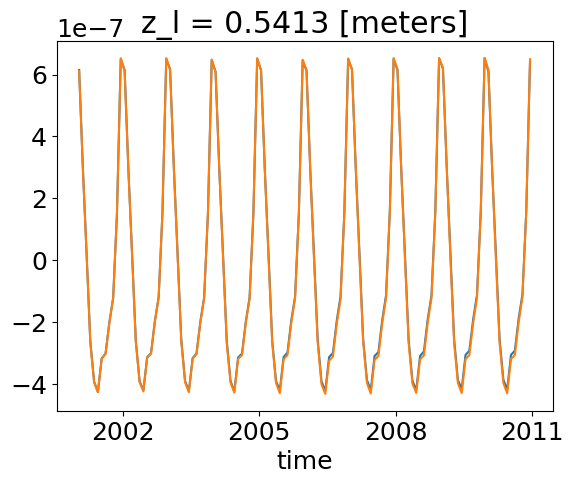

In [40]:
salt_time_C.plot()
salt_time_M.plot()

In [41]:
salt_shelf_anom.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/saltflux_shelf_time_prescribed_Pan01.nc')

### Quick comparison to ACCESS

In [42]:
salt_shelf_pan = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/saltflux_shelf_time_prescribed_Pan01.nc')
salt_shelf_acc = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/saltflux_shelf_time_prescribed_ACCESS.nc')

In [43]:
salt_shelf_pan_new = salt_shelf_pan.to_series()
salt_shelf_acc_new = salt_shelf_acc.to_series()

salt_shelf_pan_new = salt_shelf_pan_new['2001-01-01':'2010-12-16']
salt_shelf_acc_new = salt_shelf_acc_new['1910-01-01':'1919-12-16']

# Reset index to normalized months
salt_shelf_pan_new.index = range(1, len(salt_shelf_pan_new)+1)
salt_shelf_acc_new.index = range(1, len(salt_shelf_acc_new)+1)

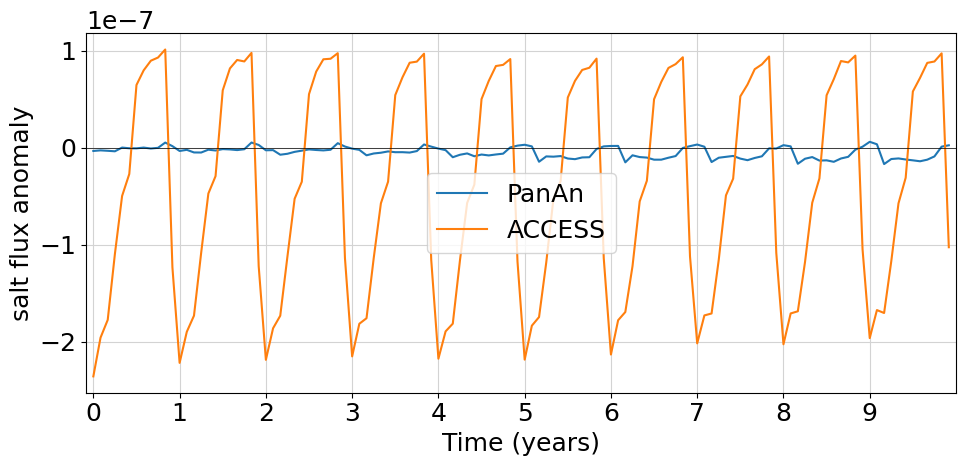

In [44]:
plt.rcParams['font.size'] = 18

plt.figure(figsize=(10, 5))
plt.plot(salt_shelf_pan_new.index, salt_shelf_pan_new.values, label='PanAn')
plt.plot(salt_shelf_acc_new.index, salt_shelf_acc_new.values, label='ACCESS')

# Set x-axis ticks to represent years 1 through 10
plt.xticks(ticks=range(1, 121, 12), labels=[str(i) for i in range(0, 10)])

# Labeling and formatting
plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel('Time (years)')
plt.ylabel("salt flux anomaly")
plt.title('')
plt.legend()
plt.xlim(0,121)
plt.grid(True, color='lightgrey')
plt.tight_layout()
plt.show()

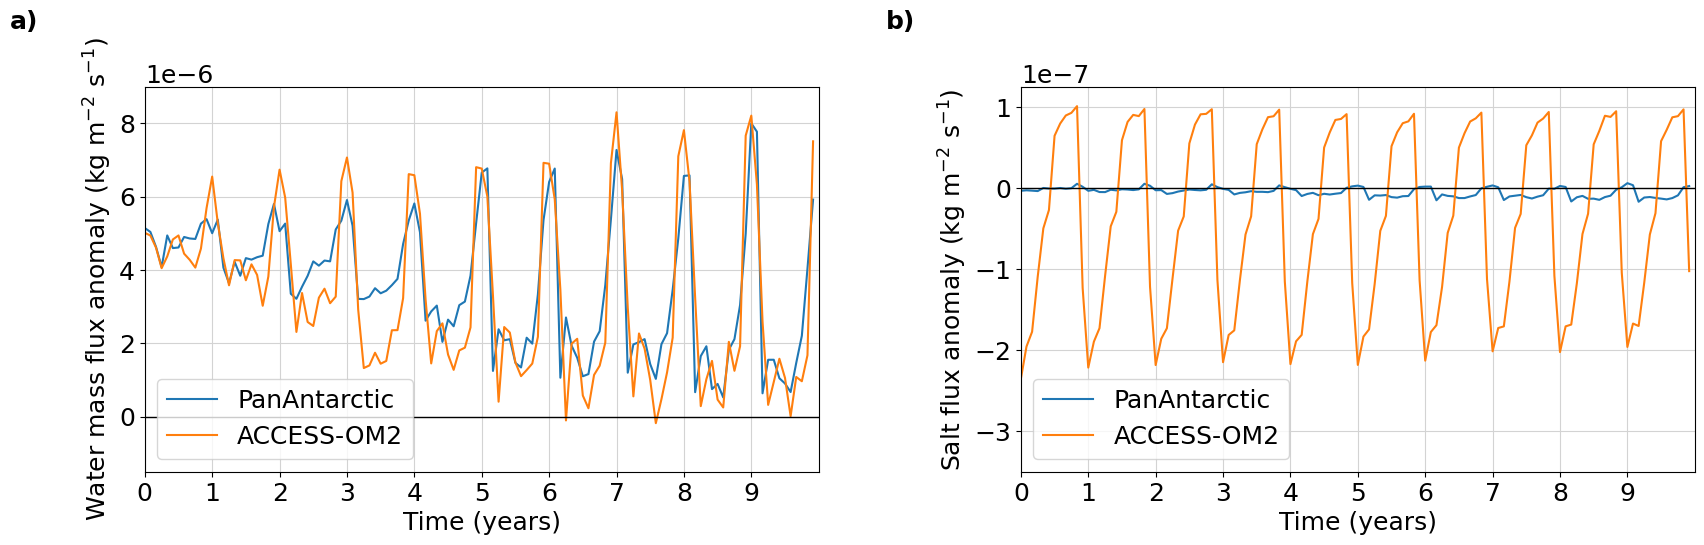

In [56]:
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 18

# Two panels: bottom and surface
datasets = [
    (wfo_shelf_pan_new, wfo_shelf_acc_new, "Water mass flux"),
    (salt_shelf_pan_new, salt_shelf_acc_new, "Salt flux"),
]

# Create figure with 2 subplots side by side
fig, axes = plt.subplots(
    nrows=1, ncols=2,
    figsize=(20, 5),
    constrained_layout=False
)

for i, (data1, data2, title) in enumerate(datasets):
    ax = axes[i]

    # Plot both resolutions
    ax.plot(data1.index, data1.values, label="PanAntarctic")
    ax.plot(data2.index, data2.values, label="ACCESS-OM2")

    # X ticks as years 1–10
    ax.set_xticks(range(1, 121, 12))
    ax.set_xticklabels([str(j) for j in range(0, 10)])

    # Horizontal zero line
    ax.axhline(0, color="black", linewidth=1)

    # Y-axis labels depend on subplot
    if i == 0:
        ax.set_ylabel("Water mass flux anomaly (kg m$^{-2}$ s$^{-1}$)")
        ax.set_ylim(-1.5e-6,9e-6)
    else:
        ax.set_ylabel("Salt flux anomaly (kg m$^{-2}$ s$^{-1}$)")
        ax.set_ylim(-3.5e-7,1.25e-7)

    # X-axis label
    ax.set_xlabel("Time (years)")
    ax.set_xlim(1,121)

    # Subplot labels (a), (b), etc.
    ax.text(-.2, 1.2, f"{chr(97+i)})", transform=ax.transAxes,
            fontsize=18, fontweight="bold", va="top", ha="left", color="black")

    # Legend + grid
    ax.legend(loc='lower left')
    ax.grid(True, color="lightgrey")

# Add space between subplots
plt.subplots_adjust(wspace=0.3)  # increase horizontal spacing (default ~0.2)

plt.show()

fig.savefig("/g/data/g40/kc5856/thesis_figures/intermodel_surfacefluxes_timeseries.png",
            dpi=300, bbox_inches='tight')